


## Learning objectives
- Calculate metrics of a regression model
- Understand why two predictors together in the same model have different slopes than if they are in separate models.

In [2]:
## our previous code...
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, statsmodels.api as sm
from scipy.stats import bernoulli
sns.set_theme()
from scipy.stats import norm
geno = pd.read_table("arabidopsis_birds/arabmagic/arabmagic_geno.csv", sep=",",skiprows=3,index_col=0)
pmap = pd.read_table("arabidopsis_birds/arabmagic/arabmagic_pmap_tair9.csv", sep=",",skiprows=3,index_col=0)
pheno = pd.read_table("arabidopsis_birds/arabmagic/arabmagic_pheno.csv", sep=",",skiprows=3,index_col=0)
counts = pd.read_table("arabidopsis_birds/eco_data/species_counts.txt")
sites = pd.read_table("arabidopsis_birds/eco_data/eco_sites.txt")
fruit_length_geno = pd.read_table("fruit_length_geno.csv",sep=",")
gwas_plus_pmap = pd.read_table("gwas_plus_pmap.csv",sep=",")

### MASC06116 model
to_model = pd.DataFrame({"fruit_length":fruit_length_geno['fruit_length'],
                         "MASC06116": (fruit_length_geno['MASC06116']=='A').astype(int)})
                                                                                    ###^^or *2
to_model = to_model.loc[pd.isnull(to_model).sum(axis=1)==0, :]

to_model = sm.add_constant(to_model)

print('MASC06116',to_model.shape)
X_marker = to_model.loc[:,['const','MASC06116']]
y_marker = to_model['fruit_length']
model_marker = sm.OLS(y_marker, X_marker).fit()
#model_marker.summary()


### height model
to_model = pd.DataFrame({"fruit_length":fruit_length_geno['fruit_length'],
                         "height": fruit_length_geno['height']})
                                                                                    ###^^or *2
to_model = to_model.loc[ pd.isnull(to_model).sum(axis=1)==0, :]

to_model = sm.add_constant(to_model)
print('height',to_model.shape)
X_height = to_model.loc[:,['const','height']]
y_height = to_model['fruit_length']
model_height = sm.OLS(y_height, X_height).fit()
#model_height.summary()

MASC06116 (674, 3)
height (511, 3)


## 5. Linear regression Model metrics
A **metric** is a formula we calculate using the data + the model to figure out how well the model fits the data

**Question**: what metrics have we discussed so far? How can we decide which single predictor is more predictive of fruit_length?

In [65]:
# needs fruit_length_geno
import pandas as pd, numpy as np, statsmodels.api as sm

fit = {}
err = {}

for unk in fruit_length_geno.columns:
    # print(f'Trying: {unk}')
    unk_int = (fruit_length_geno[unk]=='A').astype(int)
    try:
        if np.array(unk_int).sum() > 0:
            to_model = pd.DataFrame({"fruit_length":fruit_length_geno['fruit_length'],
                                     unk:unk_int})
            to_model = to_model.loc[ pd.isnull(to_model).sum(axis=1)==0, :]
            to_model = sm.add_constant(to_model)
        else:
            to_model = pd.DataFrame({"fruit_length":fruit_length_geno['fruit_length'],
                                     unk: (fruit_length_geno[unk])})
            to_model = to_model.loc[ pd.isnull(to_model).sum(axis=1)==0, :]
            to_model = sm.add_constant(to_model)
        X_fit = to_model.loc[:,['const',unk]]
        y_fit = to_model['fruit_length']
        model_unk = sm.OLS(y_fit, X_fit).fit()
        fit[unk] = model_unk.rsquared
    except ValueError:
        err[unk] = True

print(err)
rsq_all = pd.Series(fit)

{'Unnamed: 0': True}


In [53]:
[fruit_length_geno[unk] == 'A'].astype(int)

[0       True
 1       True
 2       True
 3       True
 4      False
        ...  
 672     True
 673    False
 674     True
 675    False
 676    False
 Name: MN5_26877463, Length: 677, dtype: bool]

In [48]:
fruit_length_geno[unk]

0      A
1      A
2      A
3      A
4      B
      ..
672    A
673    B
674    A
675    B
676    B
Name: MN5_26877463, Length: 677, dtype: object

In [61]:
pd.Series(fit)

bolting_days       0.008932
seed_weight        0.001888
seed_area          0.003215
ttl_seedspfruit    0.251262
branches           0.007879
                     ...   
MN5_26437895       0.000649
MN5_26438023       0.000007
MN5_26708459       0.000553
MN5_26877341       0.001725
MN5_26877463       0.001725
Length: 1259, dtype: float64

### 5.1 Residuals

The difference between our predicted average value of fruit length and the actual value is called the **residual**. You can think of this as the **error** in our prediction... the bigger the difference, the worse we did.

**Exercise 5.1.1**: Get the predictions for `model_marker` and save it in a variable called `predicted values`. Calculate the residuals  of fruit length.  

In [6]:
predicted_values = model_marker.predict()
y_marker - predicted_values

0     -0.198368
1     -1.878368
2     -1.248368
3      0.781632
4     -2.338368
         ...   
670   -0.678368
672   -0.018368
674    0.831632
675    2.041632
676    1.501632
Name: fruit_length, Length: 674, dtype: float64

You can also get this using the attribute `resid`:

In [7]:
model_marker.resid

0     -0.198368
1     -1.878368
2     -1.248368
3      0.781632
4     -2.338368
         ...   
670   -0.678368
672   -0.018368
674    0.831632
675    2.041632
676    1.501632
Length: 674, dtype: float64

**Exercise 5.1.2**: Make a strip plot or violin plot of residuals for plants separated by the 2 values of genotypeNumber (refer to Seaborn docs [here](https://seaborn.pydata.org/generated/seaborn.catplot.html))

<AxesSubplot:xlabel='MASC06116'>

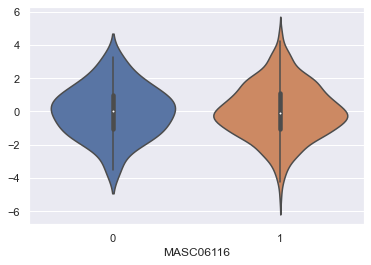

In [8]:
sns.violinplot(y= model_marker.resid, x= X_marker['MASC06116'])

**Exercise 5.1.3**: Find out whether the error in our model gets worse for taller plants by plotting height versus residual. 

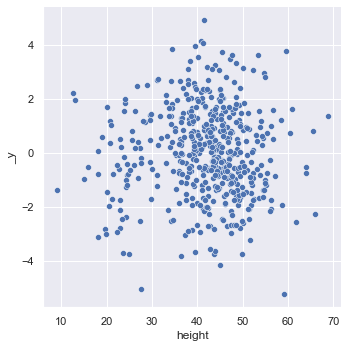

In [9]:
sns.relplot(y= model_height.resid, x=X_height['height'])

The **root mean squared error or RMSE** is a measure of how well your predictions fit the data. It is defined as:
1. square the residuals (*squared error*)
2. get the mean of the squared residuals (*mean squared error*)
3. take the square root of that (*root mean squared error*)

**Exercise 5.1.4**: Calculate Root Mean Squared Error using your predictions for the height model and for the MASC06116 model.

In [10]:
np.sqrt((model_height.resid ** 2).mean())

1.6473702911610906

You can calculate root mean squared error using the `rmse` function, alongside your predicted values as follows:

In [11]:
from statsmodels.tools.eval_measures import rmse
rmse(predicted_values, y_marker)

1.6338800442659325

### 5.2 R-squared

R-squared tells us the percent of variation in the fruit_length that is explained by the model, which we can see is 17% of the variation:

In [12]:
model_marker.rsquared

0.16990307104374025

In [13]:
fruit_length_geno['fruit_length'].var()

3.2207451545628083

**Exercise 5.2.1**: Predict the mean values based on only genotype and intercept and get the variance of these (using `var()`). Divide that by the variance of the fruit_lengths overall to calculate fraction of variance explained. Compare that to the `rsquared`.

In [14]:
model_marker.predict().var() / y_marker.var()

0.1696509893359609

In [15]:
model_height.predict().var() / y_height.var()

0.13179927940325592

In [16]:
model_height.rsquared

0.1320577093628701

**Exercise 5.2.2**: Is height a better predictor of fruit length? How can we use the summaries of the regression model to answer that question? Compare the models in 3 different metrics.

0     -0.198368
1     -1.878368
2     -1.248368
3      0.781632
4     -2.338368
         ...   
670   -0.678368
672   -0.018368
674    0.831632
675    2.041632
676    1.501632
Name: fruit_length, Length: 674, dtype: float64
1.6473702911610906


0.13179927940325592

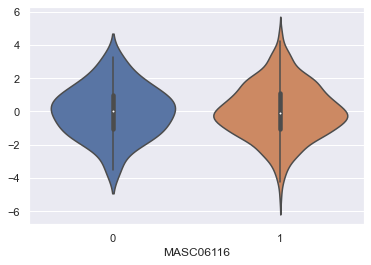

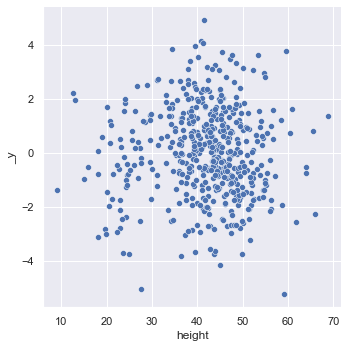

In [17]:
## Code so far

#5.1.1 - getting resid
predicted_values = model_marker.predict()
print(y_marker - predicted_values)
    # y marker is the actual fruit length values

#5.1.1 - violin of resid sorted by MASC06116
sns.violinplot(y= model_marker.resid, x= X_marker['MASC06116'])

#5.1.1 - scatter of resid vs values of height
sns.relplot(y= model_height.resid, x=X_height['height'])

#5.1.4 - getting RMSE
print(np.sqrt((model_height.resid ** 2).mean()))
    # PEMDAS:
    # ** 2 squares the value
    # .mean
    # np.sqrt takes square root

#5.2.1
model_marker.predict().var()/y_marker.var()
    # for markers
model_height.predict().var() / y_height.var()
    # for heights


## 6 Regressions with more than 1 predictor
Linear regression uses the maximum likelihood method to build a model of the **dependent variable (aka response)** feature where instead of the mean being a constant number (like 12) the mean of the model depends on the **independent variable (aka predictor)** features (fruit length mean = 12 + 3 * genotypeNumber). The value we expect for the dependent variable *depends* on the value of the independent variables.

We've been just using the first marker in fruit_length_geno to predict fruit_length. Let's try a different marker.

In [18]:
fruit_length_geno.head()

,Unnamed: 0,bolting_days,seed_weight,seed_area,ttl_seedspfruit,branches,height,pc_seeds_aborted,fruit_length,MN1_29291,...,MN5_26029439,MN5_26121184,MN5_26220737,MN5_26379737,MN5_26380009,MN5_26437895,MN5_26438023,MN5_26708459,MN5_26877341,MN5_26877463
0,MAGIC.1,15.33,17.15,0.64,45.11,10.50,NaN,0.00,14.95,A,...,A,A,B,A,B,A,A,A,A,A
1,MAGIC.2,22.00,22.71,0.75,49.11,4.33,42.33,1.09,13.27,A,...,A,A,A,A,A,A,A,B,A,A
2,MAGIC.3,23.00,21.03,0.68,57.00,4.67,50.00,0.00,13.90,A,...,A,A,B,A,B,H,A,A,A,A
3,MAGIC.4,18.67,22.45,0.74,54.33,6.33,NaN,0.23,15.93,A,...,A,A,A,A,A,A,A,A,A,A
4,MAGIC.5,18.67,25.36,0.82,38.33,5.67,42.25,0.00,12.81,B,...,B,A,A,A,A,A,A,A,B,B


**Exercise 6.1**: Using a different marker to predict fruit length (Model 2) 
1. Use the marker MASC02863 as a predictor variable and do regression predicting fruit length (save this into a variable called `model2`).

2. Write down the linear model including the coefficients of the model. 

3. Calculate the predicted mean fruit lengths and the RMSE

4. Is this marker a good predictor of fruit length? Why? Compare it to `model_marker` using at least 2 metrics. 

But there's no reason we have to pick one. We can use more than one by including it in the data frame `X`.

We will fit a linear model like this one:
    
${mean Fruit Length} = intercept + slope1 \times MASC06116 + slope2 \times MASC02863 $

(where the markers are converted into 0 and 1 as above)    

**Exercise 6.2**: Using both markers (Model 3).
1. Run the regression now including both MASC06116 and MASC02863 as predictors of fruit length  (save this into a variable called `model3`). How can we compare it to the other models?

In [54]:
to_model = pd.DataFrame({"fruit_length":fruit_length_geno['fruit_length'],
                         "MASC06116": (fruit_length_geno['MASC06116']=='A').astype(int),
                         "MASC02863": (fruit_length_geno['MASC02863']=='A').astype(int)}
                        )
###^^or *2
to_model = to_model.loc[pd.isnull(to_model).sum(axis=1)==0, :]

to_model = sm.add_constant(to_model)

X_marker = to_model.loc[:,['const','MASC06116','MASC02863']]
y_marker = to_model['fruit_length']
model_marker = sm.OLS(y_marker, X_marker).fit()

2. Write out the linear model that includes both markers, including the actual numbers of the parameters (rounded to 2 decimals).

3. There are 4 possible genotypes considering these 2 markers, which is all combinations of A and B at the 2 markers. The values are below (converted to A=1, B=0) in the data frame `genoPairs`. Use the linear model in step 2 (or, if you prefer, the `predict` function) to predict mean fruit lengths for plants in the 4 categories. Add this prediction as a column to the data frame. 

In [41]:
geno_pairs = pd.DataFrame({'MASC06116':[0,0,1,1],
                           'MASC02863':[0,1,0,1]})
geno_pairs = sm.add_constant(geno_pairs)

In [42]:
model_marker.predict(geno_pairs)

0    12.251128
1    13.072703
2    14.328108
3    15.149683
dtype: float64

4. Compare the slope parameters for model_marker, model2, and model 3. What do you notice? Add another column to the genoPairs data frame that uses the slope parameters from Model 1 and Model 2, together to make predictions. What do you notice?

### 6.1 Collinearity of two independent variables
When two independent variables have almost the same values, they can't both have a high slope if they are together in the same model. Even if when they have a high slope when they are in separate models.

We can use the `crosstab` function to see what combinations of genotypes are present across the plants.

In [20]:
pd.crosstab(fruit_length_geno['MASC06116'],
            fruit_length_geno['MASC02863'])

MASC02863,A,B
MASC06116,,
A,627,1
B,3,45


**Exercise 6.1.1**: In your own words describe the relationship between the two markers by looking at this table. 

**Exercise 6.1.2**: Make another model `model4` that has 2 predictors, but now both predictors are the genotype at marker MASC06116 (so we have 2 identical independent variables). Compare the coefficients and r-squared between Model 4 and Model 1. What do you notice?

In [ ]:
to_model = pd.DataFrame({"fruit_length":fruit_length_geno['fruit_length'],
                         "MASC06116": (fruit_length_geno['MASC06116']=='A').astype(int),
                         "MASC02863": (fruit_length_geno['MASC02863']=='A').astype(int)}
                        )
###^^or *2
to_model = to_model.loc[pd.isnull(to_model).sum(axis=1)==0, :]

to_model = sm.add_constant(to_model)

X_marker = to_model.loc[:,['const','MASC06116','MASC02863']]
y_marker = to_model['fruit_length']
model_marker = sm.OLS(y_marker, X_marker).fit()